In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
import sys, os
from skimage.io import imread

tf.__version__

'2.0.0-rc1'

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [3]:
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1

In [4]:
N, H, W = x_train.shape
D = H * W

In [5]:
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

In [6]:
latent_dim = 100

In [7]:
def build_generator(latent_dim):
    i = Input(shape=(latent_dim,))
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
    x = BatchNormalization(momentum=0.7)(x)
    x = Dense(D, activation='tanh')(x)

    model = Model(i, x)
    return model

In [8]:
def build_discriminator(img_size):
    i = Input(shape=(img_size,))
    x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
    x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    return model

In [9]:
discriminator = build_discriminator(D)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy'])

In [10]:
generator = build_generator(latent_dim)
z = Input(shape=(latent_dim,))
img = generator(z)
discriminator.trainable = False
fake_pred = discriminator(img)

combined_model = Model(z, fake_pred)
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [11]:
batch_size = 32
epochs = 10000
sample_period = 200 

ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

d_losses = []
g_losses = []

if not os.path.exists('gan_images'):
    os.makedirs('gan_images')

In [12]:
def sample_images(epoch):
    rows, cols = 5, 5
    noise = np.random.randn(rows * cols, latent_dim)
    imgs = generator.predict(noise)
    imgs = 0.5 * imgs + 0.5

    fig, axs = plt.subplots(rows, cols)
    idx = 0
    for i in range(rows):
        for j in range(cols):
            axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
            axs[i,j].axis('off')
            idx += 1
    fig.savefig("gan_images/%d.png" % epoch)
    plt.close()

In [13]:
for epoch in range(epochs):
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_imgs = x_train[idx]
    
    noise = np.random.randn(batch_size, latent_dim)
    fake_imgs = generator.predict(noise)
    
    d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
    d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_acc  = 0.5 * (d_acc_real + d_acc_fake)    
    
    noise = np.random.randn(batch_size, latent_dim)
    g_loss = combined_model.train_on_batch(noise, ones)
    
    noise = np.random.randn(batch_size, latent_dim)
    g_loss = combined_model.train_on_batch(noise, ones)
    
    d_losses.append(d_loss)
    g_losses.append(g_loss)
    
    if epoch % 100 == 0:
        print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, \
            d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
    
    if epoch % sample_period == 0:
        sample_images(epoch)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
epoch: 1/10000, d_loss: 0.75,             d_acc: 0.47, g_loss: 0.63
epoch: 101/10000, d_loss: 0.06,             d_acc: 1.00, g_loss: 3.29
epoch: 201/10000, d_loss: 0.69,             d_acc: 0.61, g_loss: 1.39
epoch: 301/10000, d_loss: 0.80,             d_acc: 0.38, g_loss: 0.75
epoch: 401/10000, d_loss: 0.69,             d_acc: 0.50, g_loss: 0.72
epoch: 501/10000, d_loss: 0.70,             d_acc: 0.48, g_loss: 0.75
epoch: 601/10000, d_loss: 0.70,             d_acc: 0.48, g_loss: 0.72
epoch: 701/10000, d_loss: 0.68,             d_acc: 0.55, g_loss: 0.73
epoch: 801/10000, d_loss: 0.65,             d_acc: 0.66, g_loss: 0.78
epoch: 901/10000, d_loss: 0.70,             d_acc: 0.58, g_loss: 0.71
epoch: 1001/10000, d_loss: 0.68,             d_acc: 0.53, g_loss: 0.72
epoch: 1101/10000, d_loss: 0.67,             d_acc: 0.61, g_loss: 0.74
epoch: 1201/10000, d_loss: 0.68,             d_acc: 0.59, g_loss: 

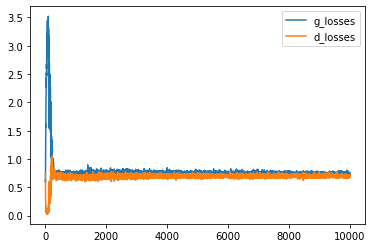

In [14]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

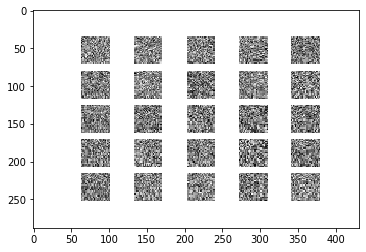

In [15]:
a = imread('gan_images/0.png')
plt.imshow(a)

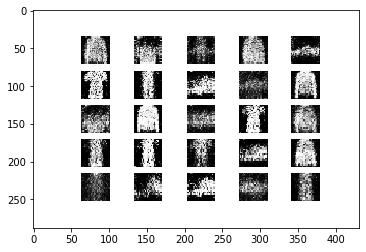

In [16]:
a = imread('gan_images/1000.png')
plt.imshow(a)

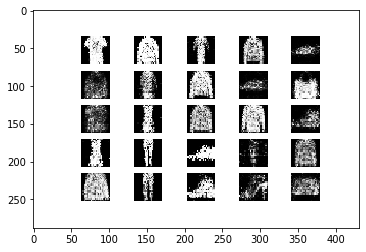

In [17]:
a = imread('gan_images/5000.png')
plt.imshow(a)

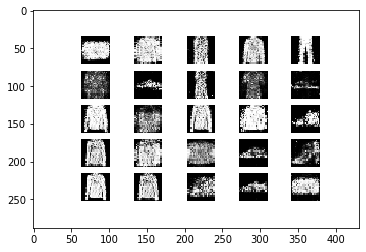

In [18]:
a = imread('gan_images/10000.png')
plt.imshow(a)